In [1]:
from __future__ import print_function
import os
import time
import h5py as h5
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, TimeDistributed, Flatten, BatchNormalization, Bidirectional, Dropout

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

print ("Numpy      ver. ", np.__version__)
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)
print ("Keras      ver. ", keras.__version__)

#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#np.random.seed(777)
#tf.set_random_seed(777)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline


Numpy      ver.  1.17.4
H5Py       ver.  2.9.0
SKLearn    ver.  0.21.3
TensorFlow ver.  1.15.0
Keras      ver.  2.2.4-tf


In [2]:
###
###  Construct TF graph
###

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tf.reset_default_graph()
RATE = 8192
DIM   = RATE
LRATE        = 1e-5   ##-4
#keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
#lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

def modelCNN3(DIM, act):
    ##########################################
    ##import GWDA.model
    ###########################################
    F = [16,32,64]
    K = [16, 8, 8]
    D = [ 1, 1, 1]
    S = [ 1, 1, 1]
    PO= [ 4, 4, 4]
    PS= [ 4, 4, 4]
    args0 = { "padding":'valid', "data_format":"channels_last" }
    ki  = keras.initializers.TruncatedNormal() ##(seed=2)
    ki0 = keras.initializers.Zeros()
    input_data = keras.layers.Input(shape=(RATE,1))
    a1=keras.layers.Conv1D(F[0], K[0], S[0], dilation_rate=D[0], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(input_data)
    a1=keras.layers.MaxPooling1D(PO[0], PS[0], **args0)(a1)
    a1=keras.layers.Conv1D(F[1], K[1], S[1], dilation_rate=D[1], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
    a1=keras.layers.MaxPooling1D(PO[1], PS[1], **args0)(a1)
    a1=keras.layers.Conv1D(F[2], K[2], S[2], dilation_rate=D[2], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
    a1=keras.layers.MaxPooling1D(PO[2], PS[2], **args0)(a1)
    a1=keras.layers.Flatten()(a1)
    a2=keras.layers.Dense(64, kernel_initializer=ki, bias_initializer=ki0, activation=act, name='fc1')(a1)
    #a2=keras.layers.Dense(1, activation=None, name='prediction')(a2)
    a2=keras.layers.Dense(1, activation=tf.nn.sigmoid, name='logit')(a2)
    return keras.models.Model(input_data, a2)

F, K = 32, 16
H1 = 64
H2 = 128
def modelLSTM(act, DN, DW):
    model = keras.Sequential()
    model.add(TimeDistributed(Conv1D(F, K, padding='valid', data_format='channels_first'), input_shape=(DN, 1, DW) ) ) 
    model.add(TimeDistributed(MaxPooling1D(pool_size=4, padding='same', data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    #model.add(LSTM(H1, activation=act, return_sequences=True))
    #model.add(Bidirectional(LSTM(H2, activation=act)))
    model.add(LSTM(H1, activation=act))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

DW, DS = 512, 256+128
DW, DS = 256, 128+64
DW, DS = 256, 256
DN = (RATE-DW)//DS
model = modelLSTM('tanh', DN, DW)

def rnn_reshape(X, DW=512, DS=256+128):
    nx, ndim = X.shape
    #assert (ndim-DW)%DS==0
    DN = (ndim-DW)//DS

    xbatch = np.zeros(shape=(nx, DN, 1, DW))
    for b in range(nx):
        for i in range(DN):
            xbatch[b,i, 0,:]=X[b,i*DS:i*DS+DW]
    return DN, xbatch

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=LRATE), 
              metrics=['accuracy', 
                       keras.metrics.Recall(), 
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.AUC(num_thresholds=64, name='roc', curve='ROC'),
                       keras.metrics.AUC(num_thresholds=64, name='pr', curve='PR')
                                          ])

model.summary()
print(model.metrics_names)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 31, 32, 241)       544       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 31, 32, 61)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 31, 1952)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                516352    
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 516,961
Trainable params: 516,961
Non-trainable params: 0
_______

In [ ]:
def visualize_conv_layer(layer_name):
  layer_output=model.get_layer(layer_name).output
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x_train[2].reshape(1,28,28,1))
  
  row_size=4
  col_size=8
  
  img_index=0
 
  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))
 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
 
      img_index=img_index+1
    
visualize_conv_layer('conv1')


Sampling rate :  8192
== Load :  /home/p00lcy01/TWCC_con/save/krnn/model_1.80.h5
 A= 1.40 : a/s:   0.996   0.986, TP/FP/TN/FN:   511     0  1051     7 roc/pr:   1.000   1.000 speed:  1392 wf/s
 A= 1.36 : a/s:   0.990   0.971, TP/FP/TN/FN:   503     0  1051    15 roc/pr:   0.998   0.998 speed:  6103 wf/s
 A= 1.31 : a/s:   0.984   0.952, TP/FP/TN/FN:   493     0  1051    25 roc/pr:   0.998   0.998 speed: 16618 wf/s
 A= 1.27 : a/s:   0.978   0.932, TP/FP/TN/FN:   483     0  1051    35 roc/pr:   0.997   0.997 speed: 17386 wf/s
 A= 1.22 : a/s:   0.962   0.886, TP/FP/TN/FN:   459     0  1051    59 roc/pr:   0.990   0.991 speed: 17288 wf/s
 A= 1.18 : a/s:   0.938   0.813, TP/FP/TN/FN:   421     0  1051    97 roc/pr:   0.983   0.984 speed: 15992 wf/s
 A= 1.13 : a/s:   0.939   0.817, TP/FP/TN/FN:   423     0  1051    95 roc/pr:   0.977   0.979 speed: 17913 wf/s
 A= 1.09 : a/s:   0.904   0.710, TP/FP/TN/FN:   368     0  1051   150 roc/pr:   0.947   0.950 speed: 15553 wf/s
 A= 1.04 : a/s:   0.890

 A= 1.04 : a/s:   0.978   0.932, TP/FP/TN/FN:   483     0  1051    35 roc/pr:   0.994   0.995 speed: 17743 wf/s
 A= 1.00 : a/s:   0.959   0.875, TP/FP/TN/FN:   453     0  1051    65 roc/pr:   0.979   0.980 speed: 19458 wf/s
 A= 0.95 : a/s:   0.943   0.826, TP/FP/TN/FN:   428     0  1051    90 roc/pr:   0.970   0.972 speed: 18568 wf/s
 A= 0.91 : a/s:   0.927   0.778, TP/FP/TN/FN:   403     0  1051   115 roc/pr:   0.951   0.954 speed: 16987 wf/s
 A= 0.86 : a/s:   0.882   0.643, TP/FP/TN/FN:   333     0  1051   185 roc/pr:   0.914   0.919 speed: 19856 wf/s
 A= 0.82 : a/s:   0.849   0.542, TP/FP/TN/FN:   281     0  1051   237 roc/pr:   0.867   0.871 speed: 15431 wf/s
 A= 0.77 : a/s:   0.814   0.436, TP/FP/TN/FN:   226     0  1051   292 roc/pr:   0.822   0.824 speed: 18237 wf/s
 A= 0.73 : a/s:   0.769   0.301, TP/FP/TN/FN:   156     0  1051   362 roc/pr:   0.733   0.721 speed: 16463 wf/s
 A= 0.68 : a/s:   0.757   0.263, TP/FP/TN/FN:   136     0  1051   382 roc/pr:   0.719   0.703 speed: 185

 A= 0.64 : a/s:   0.804   0.407, TP/FP/TN/FN:   211     0  1051   307 roc/pr:   0.779   0.775 speed: 18045 wf/s
 A= 0.59 : a/s:   0.751   0.247, TP/FP/TN/FN:   128     0  1051   390 roc/pr:   0.681   0.654 speed: 18578 wf/s
 A= 0.55 : a/s:   0.720   0.154, TP/FP/TN/FN:    80     1  1050   438 roc/pr:   0.624   0.570 speed: 18967 wf/s
 A= 0.50 : a/s:   0.706   0.110, TP/FP/TN/FN:    57     0  1051   461 roc/pr:   0.588   0.517 speed: 18238 wf/s
 A= 0.46 : a/s:   0.687   0.052, TP/FP/TN/FN:    27     0  1051   491 roc/pr:   0.559   0.466 speed: 18277 wf/s
 A= 0.41 : a/s:   0.676   0.019, TP/FP/TN/FN:    10     0  1051   508 roc/pr:   0.520   0.387 speed: 18556 wf/s
 A= 0.37 : a/s:   0.671   0.004, TP/FP/TN/FN:     2     0  1051   516 roc/pr:   0.512   0.366 speed: 17580 wf/s
 A= 0.32 : a/s:   0.672   0.006, TP/FP/TN/FN:     3     0  1051   515 roc/pr:   0.511   0.363 speed: 16042 wf/s
 A= 0.28 : a/s:   0.670   0.002, TP/FP/TN/FN:     1     0  1051   517 roc/pr:   0.504   0.344 speed: 192

 A= 0.23 : a/s:   0.670   0.002, TP/FP/TN/FN:     1     0  1051   517 roc/pr:   0.504   0.344 speed: 17820 wf/s
 A= 0.19 : a/s:   0.672   0.008, TP/FP/TN/FN:     4     0  1051   514 roc/pr:   0.504   0.344 speed: 17514 wf/s
 A= 0.14 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.501   0.334 speed: 17008 wf/s
 A= 0.10 : a/s:   0.670   0.002, TP/FP/TN/FN:     1     0  1051   517 roc/pr:   0.502   0.338 speed: 19358 wf/s
 A= 0.05 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.499   0.328 speed: 19830 wf/s
 A= 0.01 : a/s:   0.669   0.000, TP/FP/TN/FN:     0     1  1050   518 roc/pr:   0.500   0.329 speed: 19891 wf/s
== Load :  /home/p00lcy01/TWCC_con/save/krnn/model_0.80.h5
 A= 1.40 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     1  1050     0 roc/pr:   1.000   1.000 speed: 17239 wf/s
 A= 1.36 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     2  1049     0 roc/pr:   0.999   0.996 speed: 15287 wf/s
 A= 1.31 : a/s:   1.000   1.000, TP/FP/TN/FN:

 A= 1.31 : a/s:   0.992   1.000, TP/FP/TN/FN:   518    12  1039     0 roc/pr:   0.996   0.983 speed: 18164 wf/s
 A= 1.27 : a/s:   0.997   1.000, TP/FP/TN/FN:   518     5  1046     0 roc/pr:   0.999   0.994 speed: 17664 wf/s
 A= 1.22 : a/s:   0.994   1.000, TP/FP/TN/FN:   518     9  1042     0 roc/pr:   0.997   0.989 speed: 18013 wf/s
 A= 1.18 : a/s:   0.994   1.000, TP/FP/TN/FN:   518    10  1041     0 roc/pr:   0.998   0.992 speed: 19898 wf/s
 A= 1.13 : a/s:   0.996   1.000, TP/FP/TN/FN:   518     6  1045     0 roc/pr:   0.998   0.990 speed: 17433 wf/s
 A= 1.09 : a/s:   0.995   1.000, TP/FP/TN/FN:   518     8  1043     0 roc/pr:   0.999   0.994 speed: 19146 wf/s
 A= 1.04 : a/s:   0.994   1.000, TP/FP/TN/FN:   518    10  1041     0 roc/pr:   0.998   0.992 speed: 20021 wf/s
 A= 1.00 : a/s:   0.994   1.000, TP/FP/TN/FN:   518    10  1041     0 roc/pr:   0.999   0.996 speed: 18609 wf/s
 A= 0.95 : a/s:   0.994   1.000, TP/FP/TN/FN:   518    10  1041     0 roc/pr:   0.997   0.987 speed: 192

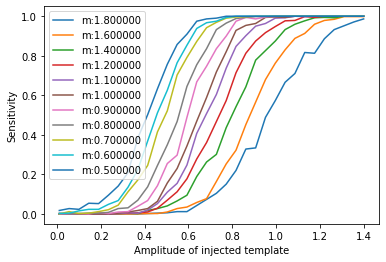

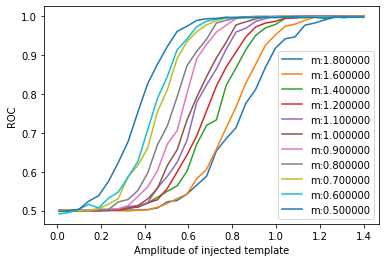

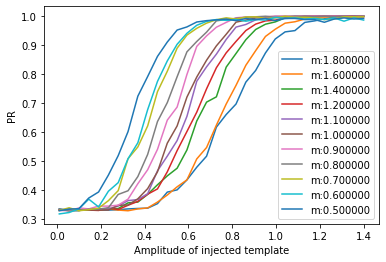

In [4]:
###
###  Testing...
###
#ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_model'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_relu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_elu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/krnn'


import GWDA.loader

NOISE_COPY = 2
H5_FILE="../white_h_8192_dm2.h5"
GWdata = GWDA.loader.GWInject(H5_FILE, plot=0)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

BATCH = 8192
TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TEST_LIST = np.linspace(1.4, 0.01, 32)

with tf.Session() as sess:
    tf.global_variables_initializer().run()

    #fig1 = plt.figure()
    #fig2 = plt.figure()
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    
    for m in TRAIN_A:
        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("== Load : ", CKPT)
        except: 
            print("== Found no file ", CKPT)
            continue
        
        gout=[]
        for amp in TEST_LIST:

            X, Y  = GWdata.get_test_set(A=amp, nc=NOISE_COPY)
            #X = np.expand_dims(X, axis=-1)  
            DN, X = rnn_reshape(X, DW=DW, DS=DS)
            
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=222)

            time0 = time.time()

            #el, ea, er, etp, efp, etn, efn, eroc, epr = model.evaluate(Xts, Yts, verbose=0, batch_size=512)
            eout = model.evaluate(Xts, Yts, verbose=0, batch_size=512)
            
            gout.append(eout)
            print(" A= %4.2f : a/s: %7.3f %7.3f, TP/FP/TN/FN: %5d %5d %5d %5d roc/pr: %7.3f %7.3f speed: %5d wf/s" 
                  % (amp, eout[1], eout[2], eout[3], eout[4], eout[5], eout[6], eout[7], eout[8], len(Yts)/(time.time()-time0) ) )

        gout = np.array(gout)
        ax1.plot(TEST_LIST, gout[:,2], label="m:%f"%m)
        ax2.plot(TEST_LIST, gout[:,7], label="m:%f"%m)
        ax3.plot(TEST_LIST, gout[:,8], label="m:%f"%m)

        with open("%s/his_test.log" % (ROOT_FOLDER), 'a') as f:
            f.write("### A=%4.2f\n" % (amp)  )
            for i in range( len(TEST_LIST) ):
                f.write("%5f %s\n" % ( TEST_LIST[i], " ".join(str(item) for item in gout[i,:])) )
            f.write("\n\n")

    
    FIGNAME = "%s/infer.png" % (ROOT_FOLDER)
    ax1.set_xlabel("Amplitude of injected template")
    ax1.set_ylabel("Sensitivity")
    ax1.legend()
    fig1.savefig(FIGNAME)
    FIGNAME_ROC = "%s/infer_roc.png" % (ROOT_FOLDER)
    ax2.set_xlabel("Amplitude of injected template")
    ax2.set_ylabel("ROC")
    ax2.legend()
    fig2.savefig(FIGNAME_ROC)
    FIGNAME_PR = "%s/infer_pr.png" % (ROOT_FOLDER)
    ax3.set_xlabel("Amplitude of injected template")
    ax3.set_ylabel("PR")
    ax3.legend()
    fig3.savefig(FIGNAME_PR)

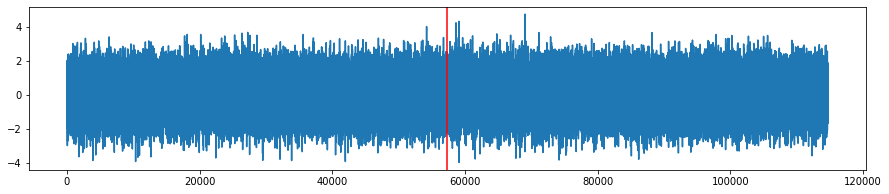

Load :  /home/p00lcy01/TWCC_con/save/krnn/model_1.40.h5
Load :  /home/p00lcy01/TWCC_con/save/krnn/model_1.00.h5
Load :  /home/p00lcy01/TWCC_con/save/krnn/model_0.60.h5


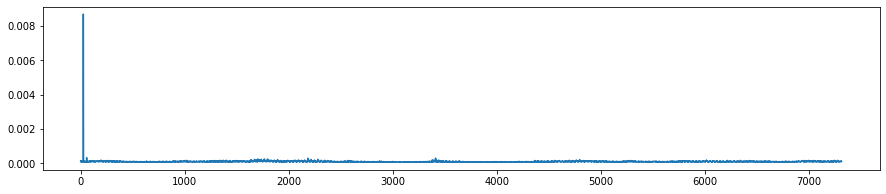

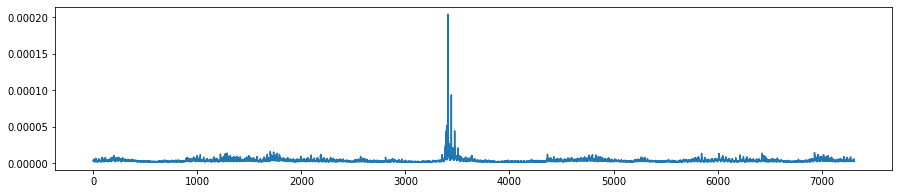

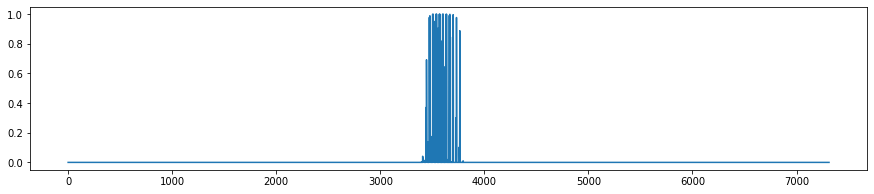

In [7]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

#ROOT_FOLDER = './model'
#ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.0]
TRAIN_A =   [1.4, 1.0, 0.6]

SKIP = RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("../real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.axvline(0.5*len(data), color='r')
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 8   ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 512
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE])

            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:] = data[s:s+RATE]

            ### reshape    
            DN, xbatch = rnn_reshape(xbatch, DW=256, DS=256)
            #print (xbatch.shape)    
                
            p_ = model.predict(xbatch, verbose=0)

            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        plt.plot(prob[3000:-3000])


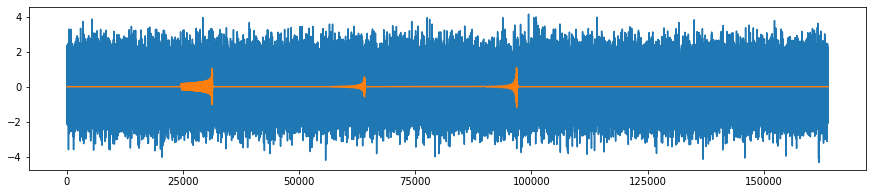

Load :  /home/p00lcy01/TWCC_con/save/krnn/model_1.40.h5
Load :  /home/p00lcy01/TWCC_con/save/krnn/model_1.00.h5
Load :  /home/p00lcy01/TWCC_con/save/krnn/model_0.60.h5


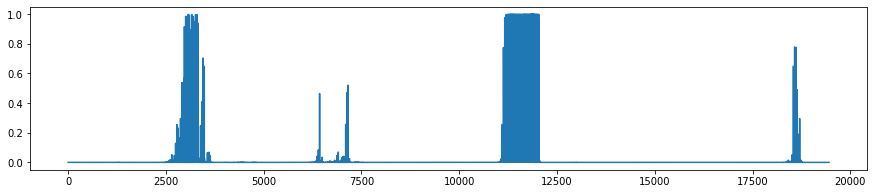

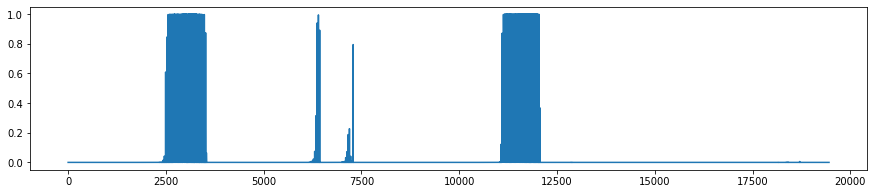

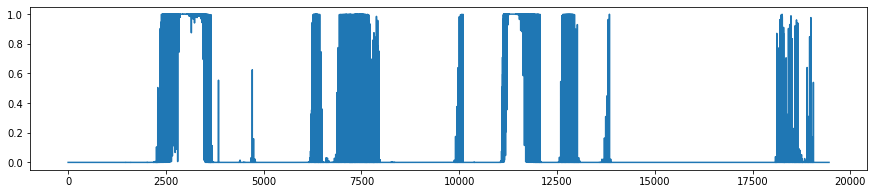

In [9]:
###
###  Testing fake data...
###
wopt = {"figsize": (15,3) }

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.6, 1.0, 0.8, 0.6]
TRAIN_A =   [1.4, 1.0, 0.6]

def gen3():
    A=[0.9,0.5,1]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['train_hp'][110]
    inj2 = tmp.f['train_hc'][70]
    inj3 = tmp.f['train_hc'][90]

    data  = np.random.normal(0,1,RATE*20)
    data[3*RATE:4*RATE] += A[0]*inj1
    data[7*RATE:8*RATE] += A[1]*inj2
    data[11*RATE:12*RATE] += A[2]*inj3
    exact = np.zeros(RATE*20)
    exact[3*RATE:4*RATE] += A[0]*inj1
    exact[7*RATE:8*RATE] += A[1]*inj2
    exact[11*RATE:12*RATE] += A[2]*inj3
    return exact, data

def gen1():
    A=[0.9]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['train_hc'][120]

    data  = np.random.normal(0,1,RATE*3)
    data[RATE:2*RATE] += A[0]*inj1
    exact = np.zeros(RATE*3)
    exact[RATE:2*RATE] += A[0]*inj1
    return exact, data

exact, data = gen3()

plt.figure(**wopt)
plt.plot(data)
plt.plot(exact)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #saver = tf.train.Saver(max_to_keep=50)

    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 8    ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 256
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE])
            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:] = data[s:s+RATE]
                
            ## reshape    
            DN, xbatch = rnn_reshape(xbatch, DW=256, DS=256)
    
            p_ = model.predict(xbatch, verbose=0)
            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        plt.plot(prob.flatten())

